# Benchmarks to decide on the best document vector representation for clustering

In [238]:
import numpy as np
import scipy as sp
from scipy import sparse
import pickle
import os
import sys
import time
import timeit
from pandas import DataFrame
from matplotlib import pyplot as plt
from operator import itemgetter

### Load the vectorized data

In [83]:
datapath = '/home/matt/Git/TextMiningFinal/data/vectors/'
with open(os.path.join(datapath,'20_newsgroups_simple.p'),'rb') as docfile:
    docs = pickle.load(docfile)

### Functions we'll need

In [258]:
# add two integer-keyed dicts as if they were vectors
def add_dicts(*vecs):
    v1 = vecs[0]
    v2 = vecs[1]
    keys = set(v1).union(v2) if len(v1)<len(v2) else set(v2).union(v1)
    result = {}
    for key in keys:
        result[key] = v1.get(key,0) + v2.get(key,0)
    return result

In [259]:
# reduce the indices of the docs to range(0,total_distinct_indices_in_docs): makes for smaller np arrays
def compress_indices(docs):
    # collect all the indices that actually appear
    indices = {}
    newdocs = []
    i = 0
    for doc in docs:
        newdoc = {}
        for key in doc:
            index = indices.get(key,i)
            newdoc[index] = doc[key]
            if index==i:
                indices[key] = i
                i+=1
        newdocs.append(newdoc)
    return newdocs,len(indices)

In [260]:
# reduce the indices of the docs to range(0,total_distinct_indices_in_docs): makes for smaller np arrays
def compress_indices2(docs):
    # collect all the indices that actually appear
    indices = set()
    docs = list(docs)
    for doc in docs:
        for key in doc:
            indices.add(key)
    # now connect them to new indices
    mapping = dict(zip(indices,range(len(indices))))
    newdocs = []
    for doc in docs:
        newdoc = {}
        for key in doc:
            newdoc[mapping[key]] = doc[key]
        newdocs.append(newdoc)
    # return both the new docs and the total number of indices, for properly shaping numpy arrays later
    return newdocs, len(indices)

In [261]:
# convert sparse dict representation to a dense numpy array with the specified size
def dict_to_np(d,length):
    v = np.zeros((1,length),dtype='float')
    for k,c in d.items():
        v[0,k] = c
    return v

### Tests on some dummy data

In [262]:
d1={0:1,1:2,2:3}
d2={2:3,4:5,5:6}
set(d1).union(d2)

{0, 1, 2, 4, 5}

In [263]:
add_dicts(d1,d2)

{0: 1, 1: 2, 2: 6, 4: 5, 5: 6}

In [264]:
# note the zeros being filled in to non-indexed positions
print(dict_to_np(d1,6))
print(dict_to_np(add_dicts(d1,d2),6))

[[ 1.  2.  3.  0.  0.  0.]]
[[ 1.  2.  6.  0.  5.  6.]]


In [265]:
# and note here that the indices 4 and 5 get decremented, since the index 3 is never used
compress_indices([d1,d2])

([{0: 1, 1: 2, 2: 3}, {2: 3, 3: 5, 4: 6}], 5)

In [266]:
# and note here that the indices 4 and 5 get decremented, since the index 3 is never used
compress_indices2([d1,d2])

([{0: 1, 1: 2, 2: 3}, {2: 3, 3: 5, 4: 6}], 5)

In [267]:
%timeit compress_indices(map(itemgetter(2),docs))

1 loops, best of 3: 235 ms per loop


In [268]:
%timeit compress_indices2(map(itemgetter(2),docs))

1 loops, best of 3: 241 ms per loop


## Tests on samples of our real data

In [269]:
# Reduce the indices and set the vocab size
vdocs, V = compress_indices(map(itemgetter(2),docs))

In [270]:
V
# 7662, the right number according to the notebook that vectorized the corpus

7662

In [280]:
def get_best_time(func,*args,iterations=10):
    times = []
    for i in range(iterations):
        start = time.time()
        func(*args)
        end = time.time()
        times.append(end-start)
    return min(times)

In [322]:
sample_size = 100
iterations = 30
results = DataFrame(index = range(sample_size),columns= ['np','dict','csr','coo','dok'])

for i in results.index:
    # choose two random docs
    indices = np.random.randint(0,len(vdocs),2)

    # get their vectors as dicts
    d1 = vdocs[indices[0]]
    d2 = vdocs[indices[1]]

    # translate them to numpy arrays
    v1 = dict_to_np(d1,V)
    v2 = dict_to_np(d2,V)
    
    # translate to all the scipy sparse types
    v1_dok = sparse.dok_matrix(v1)
    v2_dok = sparse.dok_matrix(v2)

    v1_coo = sparse.coo_matrix(v1)
    v2_coo = sparse.coo_matrix(v2)

    v1_csr = sparse.csr_matrix(v1)
    v2_csr = sparse.csr_matrix(v2)
    
    # apply all the binary functions to them
    ops = [np.add,add_dicts,np.add,np.add,np.add]
    args = [(v1,v2),(d1,d2),(v1_csr,v2_csr),(v1_coo,v2_coo),(v1_dok,v2_dok)]
    times = [get_best_time(ops[i],*args[i],iterations=iterations) for i in range(len(ops))]
    
    # and store the results
    results.loc[i,['np','dict','csr','coo','dok']] = times

In [323]:
# numpy dense is the clear winner!
results.mean()

np      0.000004
dict    0.000071
csr     0.000121
coo     0.000250
dok     0.002518
dtype: float64

## Plot results on log2 scale: every increase of 1 in y means a doubling of execution time

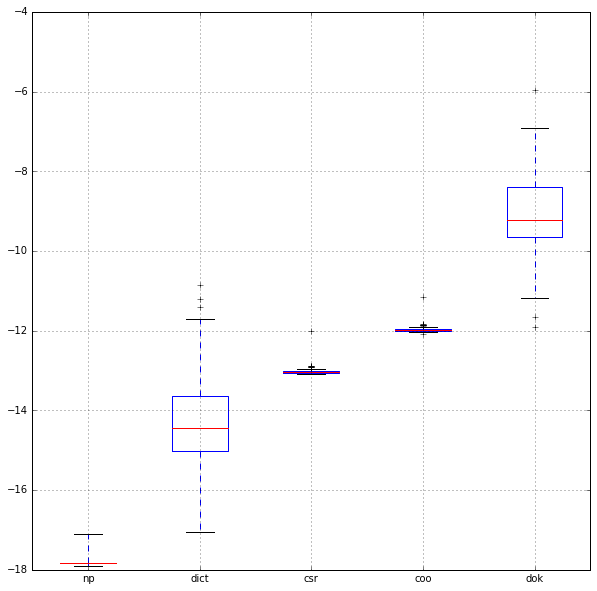

In [346]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 10,10
results.applymap(np.log2).plot.box(grid=True)#ylim=(0,.001))

### Summary: plain old numpy beats everything else with flying colors (and note that our plain old dict implementation beats all the sparse implementations at least 3-fold, albeit with higher variance).  Since the maximum dimension of our datasets is ~10000 this shouldn't be a problem.  Moreover, this will allow us to use a common implementation of clustering for both topic vectors and term vectors, since numpy makes the most sense in the topic vector case from the start, with dimensionality only in the hundreds.

## Here is the memory size of the whole corpus in different formats:

In [366]:
print("Size of corpus (Mb) in numpy format:")
print("%d Mb" %(sum([sys.getsizeof(dict_to_np(doc,V)) for doc in vdocs])/(1024**2)))
print("Size of corpus in dict format:")
print("%d Mb" %(sum([sys.getsizeof(doc) for doc in vdocs])/(1024**2)))
print("Size of corpus (Mb) in sparse csr format:")
print("%f Mb" %(sum([sys.getsizeof(sparse.csr_matrix(dict_to_np(doc,V))) for doc in vdocs])/(1024**2)))
print("Size of corpus (Mb) in sparse coo format:")
print("%f Mb" %(sum([sys.getsizeof(sparse.coo_matrix(dict_to_np(doc,V))) for doc in vdocs])/(1024**2)))
print("Size of corpus (Mb) in sparse dok format:")
print("%f Mb" %(sum([sys.getsizeof(sparse.dok_matrix(dict_to_np(doc,V))) for doc in vdocs])/(1024**2)))

Size of corpus (Mb) in numpy format:
662 Mb
Size of corpus in dict format:
35 Mb
Size of corpus (Mb) in sparse csr format:
0.604233 Mb
Size of corpus (Mb) in sparse coo format:
0.604233 Mb
Size of corpus (Mb) in sparse dok format:
47.694031 Mb


## Obviously there's a huge blow-up in memory usage from sparse to dict to numpy, 1000-fold overall, but for our dataset it's simply not an issue; we have 662 Mb to spare.
### (note that we're beating the scipy dok format in memory usage and destroying it completely in execution time with just a dict implementation)